In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from itertools import product
from numba import jit

In [2]:
def E(data,w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    d = w.shape[0]
    correlations = np.sum(np.multiply((data@((1-np.eye(d))*w)), data), axis = 1)/2
    local_field = data@theta

    return -(correlations + local_field)

def E_indep(data, w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    local_field = data@theta

    return -local_field

def p_star(data,w,theta, Energy_functional = E):
    return np.exp(-Energy_functional(data,w,theta))

def p(data,w,theta,Z, Energy_functional = E):
    return 1/Z * p_star(data,w,theta, Energy_functional)

def partition(w, theta, all_states, Energy_functional = E):
    return np.sum(p_star(all_states, w , theta, Energy_functional))

def log_likelihood(w, theta, data, Z, Energy_functional = E):
    return 1/len(data) * np.sum(np.log(p(data,w,theta, Z, Energy_functional)))

In [4]:
def clamped_statistics(data):
    single = np.mean(data, axis = 0)
    double = np.einsum('ki,kj-> ij', data, data)/(len(data))

    return single, double

def free_statistics(w, theta, all_states, Z, Energy_functional = E):
    all_probs = p(all_states, w, theta, Z, Energy_functional)
    single = np.einsum('ki, k -> i', all_states, all_probs)
    double = np.einsum('ki, kj, k -> ij', all_states, all_states, all_probs)
    return single, double


In [37]:
w = np.array([[0,0,0],[0,0,0],[0,0,0]])
theta = np.array([0,0,0])
all_states = list(product([0,1], repeat = w.shape[0]))
all_states = np.array([np.array(s) for s in all_states])
free_statistics(w,theta, all_states)

(array([0.5, 0.5, 0.5]),
 array([[0.5 , 0.25, 0.25],
        [0.25, 0.5 , 0.25],
        [0.25, 0.25, 0.5 ]]))

In [5]:
lr = 1e-3
threshold = 1e-13
N = 1000
S = 10

# generate the data 
np.random.seed(42)
data_toy = np.array([np.random.randint(0, 2, size = S) for _ in range(N)])
for point in data_toy:
    point[point ==0] = -1
all_states = list(product([-1,1], repeat = S))
all_states = np.array([np.array(s) for s in all_states])

In [148]:
def BM(data, lr , threshold, momentum = 0, random = False, print_iter = 500, Energy_functional = E, seed = None, MH_stats = False, MH_threshold = 1e-4, n_samples = 100, MF_LR_stats = False, m_threshold = 1e-2):
    #compute the clamped statistics
    if seed:
        np.random.seed(seed)
    clamped_single, clamped_double = clamped_statistics(data)
    S = data.shape[1]
    #initialize w and theta (random/zeros)
    if random:
        w = np.random.randn(S,S)
        w = np.tril(w) + np.tril(w, -1).T
        np.fill_diagonal(w,0.) 
        theta = np.random.randn(S)
    else:
        w = np.zeros((S,S))
        theta = np.zeros(S)

    error = np.inf
    gradient_old_single = np.zeros(theta.shape[0])
    gradient_old_double = np.zeros(w.shape[0])

    i=0
    if MH_stats:
        pattern = np.random.randint(0, 2, size = S)
        pattern[pattern == 0] = -1
        error_list = []
    Z = partition(w,theta, all_states, Energy_functional)   
    likelihoods = [log_likelihood(w,theta,data, Z, Energy_functional)]
    while error > threshold:
        i += 1      
        #compute the free statistics
        Z = partition(w,theta, all_states, Energy_functional)
        if MH_stats:
            free_single, free_double, pattern = MH_sampler(w, theta, pattern, n_samples)
        elif MF_LR_stats:
            free_single, free_double = MF_LR_Sampler(w, theta, m_threshold)
        else:
            free_single, free_double = free_statistics(w,theta,all_states, Z, Energy_functional)

        #calculating the new gradients
        gradient_single = clamped_single - free_single
        #setting the diagonal zero
        gradient_double = (1-np.eye(w.shape[0]))*(clamped_double - free_double)

        if np.allclose(gradient_double, gradient_old_double, rtol = 0, atol = 0):
            print("ref mistake")
            break

        #updating w and theta
        theta_new = theta + lr * gradient_single + momentum * gradient_old_single
        w_new = w + lr * gradient_double + momentum * gradient_old_double

        #determine error
        if MH_stats:
            error_real_theta = np.mean(theta_new - theta)
            error_real_w = np.mean(w_new - w)
            error_real = max(error_real_theta, error_real_w)
        error_theta = np.mean(np.abs(theta_new - theta)) 
        error_w = np.mean(np.abs(w_new - w))
        if Energy_functional is E_indep:
            error_w = 0
        error = max(error_theta, error_w)

        theta = theta_new
        w = w_new

        if MH_stats:
            error_list.append(error_real)
            last_10 = error_list[-10:]
            ratio = np.abs(np.sum(last_10)/np.sum(np.abs(last_10)))
            if ratio < MH_threshold:
                print("ratio: ", ratio)
                break
            elif i % print_iter == 0:
                print("ratio:", ratio) 
                
                



        gradient_old_single =  gradient_single
        gradient_old_double =  gradient_double

        likelihoods.append(log_likelihood(w,theta,data,Z, Energy_functional))

        if i % print_iter == 0:
            print(i)
            print(error)
            if Energy_functional is E_indep:
                print(error_theta)
                print(free_single)
    # print(np.abs(clamped_double - free_double))
    return w, theta, likelihoods

In [10]:
w_exact_toy, theta_exact_toy, likelihoods_exact_toy = BM(data_toy, lr, threshold, momentum = 0.01)

500
1.9809741282852328e-06
1000
3.2574456551575247e-08
1500
5.884754084159102e-10
2000
1.0772966568296793e-11
2500
1.9792410332203357e-13


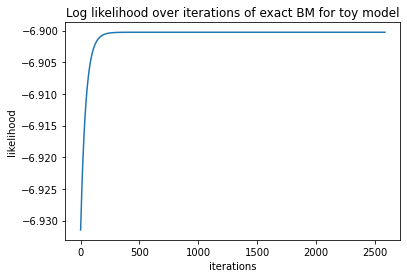

In [11]:
plt.plot([x for x in range(len(likelihoods_exact_toy))], likelihoods_exact_toy)
plt.xlabel("iterations")
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM for toy model")
plt.show()

Note that the above plot already starts quite high, most likely due to the fact that we opted to start with a weight matrix and bias vector that are zero. Since we can assume that for the toy model the spins do not have a true underlying correlation between them.

## Salamander data

In [12]:
salamander = np.loadtxt('bint.txt')
for point in salamander:
    point[point == 0] = -1

In [13]:
train_salamander = salamander[:,:953]
part_indices = np.random.choice(range(160), size = 10, replace = False)
train_salamander_part = train_salamander[part_indices]
train_salamander_part = train_salamander_part.transpose()

In [101]:
threshold_salamander = 1e-5
lr_salamander = 1e-3
mom_salamander = 0.01

w_exact_sal, theta_exact_sal, likelihoods_exact_sal = BM(train_salamander_part, lr_salamander, threshold_salamander, momentum = mom_salamander, random = True, seed = 2)

500
0.00044582339039668517
1000
0.00017733730482844586
1500
0.00013172186441129619
2000
9.420547681868405e-05
2500
7.391569700726581e-05
3000
5.955277574935275e-05
3500
4.988338741496788e-05
4000
4.304750884757666e-05
4500
3.783197556070636e-05
5000
3.365826074859676e-05
5500
3.0268836998612186e-05
6000
2.7613778384691922e-05
6500
2.544985458431126e-05
7000
2.357364637870507e-05
7500
2.1914189268277955e-05
8000
2.0425403711421056e-05
8500
1.9519564537473498e-05
9000
1.8705599724017085e-05
9500
1.7949279284240615e-05
10000
1.724142297043485e-05
10500
1.6575583331671083e-05
11000
1.594718491942371e-05
11500
1.535291168667241e-05
12000
1.4790274756806832e-05
12500
1.4257313090620949e-05
13000
1.3752392011198711e-05
13500
1.3274072789612457e-05
14000
1.2821032543672284e-05
14500
1.2392018513207592e-05
15000
1.1985824736668315e-05
15500
1.1686288915493947e-05
16000
1.141729530843849e-05
16500
1.116003577876501e-05
17000
1.0913820449545696e-05
17500
1.0677996873559303e-05
18000
1.04519539983

In [96]:
from collections import Counter

Z_dep = partition(w_exact_sal, theta_exact_sal, all_states)

#observed rate deter
full_data = salamander[part_indices]
full_data = full_data.transpose()

full_data = full_data.tolist()
new_data = map(tuple, full_data)
new_data_set = [list(item) for item in set(tuple(row) for row in full_data)]

observed_occ = Counter(new_data)

observed_rate = []
for i in new_data_set:
    observed_rate.append(observed_occ[tuple(i)]/len(full_data))

approximated_rate = p(new_data_set, w_exact_sal, theta_exact_sal, Z_dep)

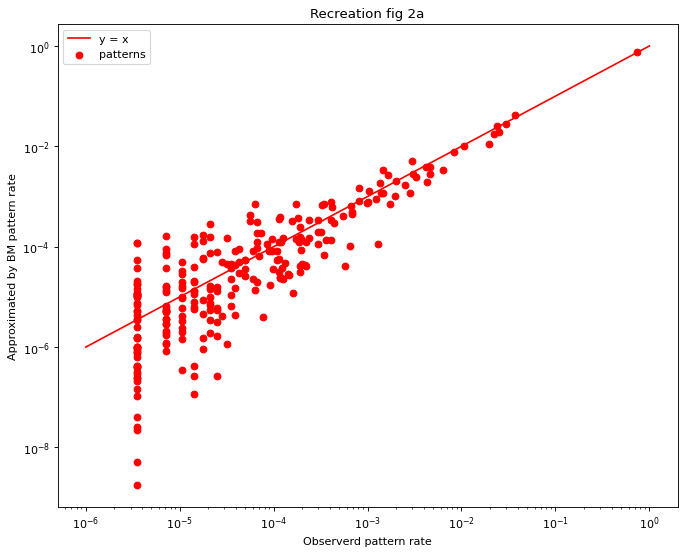

In [97]:
plt.figure(figsize = (10,8), dpi = 80, facecolor=(1, 1, 1))
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")      
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_Only_dep.png")
plt.show()

#### Creating the indep model

In [23]:
w_indep, theta_indep, liks_indep = BM(train_salamander_part, lr_salamander * 10 **(1), threshold_salamander * 10**(2), mom_salamander, Energy_functional= E_indep)

Threshold verandering voor plotjes genereren.

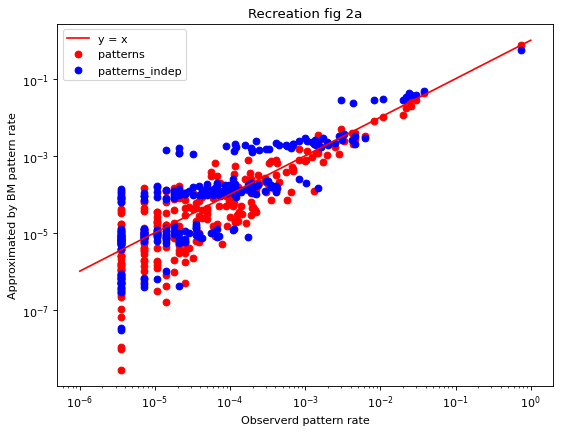

In [26]:
Z_indep = partition(w_indep, theta_indep, all_states, Energy_functional= E_indep)

approximated_rate_indep = p(new_data_set, w_indep, theta_indep, Z_indep, Energy_functional= E_indep)

plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_indep, label = "patterns_indep", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_with_indep")
plt.show()


## Metropolis Hastings Sampling

In [27]:
def E_difference(pattern, site, w, theta):
    return 2*pattern[site] * np.dot(w[site], pattern) + 2 * pattern[site] * theta[site]
    

In [129]:
def MH_sampler(w, theta, pattern, n_samples):    
    
    d = w.shape[0]
    
    # store the samples somewhere
    samples = np.zeros((n_samples, d))
    
    # get initial energy 
    energy = E(np.array([pattern]),w, theta)[0]
    
    # Precompute random numbers
    random_values = np.random.rand((n_samples + 1) * len(theta))
    random_flip_sites = np.random.randint(0, len(theta), size= (n_samples + 1)* len(theta))
    n_accept = 0
    for i in range(n_samples):
        for j in range(len(theta)):
            diff = E_difference(pattern,random_flip_sites[i*j + j], w, theta)
            a = np.exp(-diff)
            if a > random_values[i*j + j]:
                pattern[random_flip_sites[i*j + j]] *=-1
                energy += diff
                n_accept +=1
        samples[i] = pattern    
    # samples[-1] = pattern
    # print(samples[-1])
    single = np.mean(samples, axis = 0)
    double = np.einsum('ki, kj -> ij', samples, samples)/len(samples)

    return single, double, pattern

In [29]:
print(np.mean([x[0] for x in data_toy]))

0.014


In [130]:
w_mh, theta_mh, liks_mh  = BM(data_toy, 1e-3, threshold, random = True, momentum= 0.01, seed = 42,  MH_stats= True, n_samples= 1000, print_iter= 1)

1
0.000802
2
0.00899519999999996
3
0.010549600000000027
4
0.008923599999999999
5
0.010377999999999995
6
0.009870199999999999
7
0.008885799999999994
8
0.004407600000000003
9
0.004292760000000006
10
0.008372400000000002
11
0.008084
12
0.0050107999999999715
13
0.004129800000000009
14
0.005572400000000024
15
0.007105199999999964
16
0.007474399999999981
17
0.003798360000000007
18
0.003750759999999998
19
0.003583200000000035
20
0.004089000000000005
21
0.005073199999999984
22
0.003426799999999998
23
0.004014320000000005
24
0.004852999999999991
25
0.0037681999999999967
26
0.0035024399999999977
27
0.003849599999999985
28
0.004802599999999979
29
0.004043
30
0.004044600000000006
31
0.00367100000000002
32
0.004331400000000011
33
0.004077800000000029
34
0.003098160000000005
35
0.004030400000000003
36
0.0039936000000000095
37
0.005128000000000013
38
0.003423400000000039
39
0.003274600000000015
40
0.0038718000000000025
41
0.004544400000000023
42
0.003971800000000008
43
0.0039050000000000035
44
0.0033

KeyboardInterrupt: 

In [153]:
w_mh_sal, theta_mh_sal, liks_mh_sal  = BM(train_salamander_part, 1e-3, 1e-5, momentum= 0, random = False, seed = 2,  MH_stats= True, MH_threshold= 5e-2, n_samples= 1000, print_iter= 10)

ratio: 1.0
10
0.000917581741867786
ratio: 1.0
20
0.0009325817418677863
ratio: 1.0
30
0.0008977817418677859
ratio: 1.0
40
0.0008989817418677854
ratio: 1.0
50
0.0008533817418677848
ratio: 1.0
60
0.0008505817418677862
ratio: 1.0
70
0.0008553817418677876
ratio: 1.0
80
0.0008365817418677868
ratio: 1.0
90
0.0008311817418677869
ratio: 1.0
100
0.0007275817418677874
ratio: 1.0
110
0.0007015817418677877
ratio: 1.0
120
0.0006701817418677855
ratio: 1.0
130
0.0006149817418677844
ratio: 1.0
140
0.0005631817418677882
ratio: 1.0
150
0.0004941817418677857
ratio: 1.0
160
0.0004415817418677831
ratio: 1.0
170
0.00043178174186778856
ratio: 1.0
180
0.0004087817418677864
ratio: 1.0
190
0.0004783817418677852
ratio: 1.0
200
0.0002579817418677854
ratio: 1.0
210
0.00022198174186778552
ratio: 1.0
220
0.0003137817418677885
ratio: 1.0
230
0.0002291817418677844
ratio: 1.0
240
0.0002291817418677844
ratio: 1.0
250
0.00019018174186778702
ratio: 1.0
260
0.0003013817418677844
ratio: 1.0
270
0.0003223817418677888
ratio: 1

In [119]:
print(np.mean(salamander, axis = 0))

[-0.975  -0.975  -0.9875 ... -0.975  -1.     -1.    ]


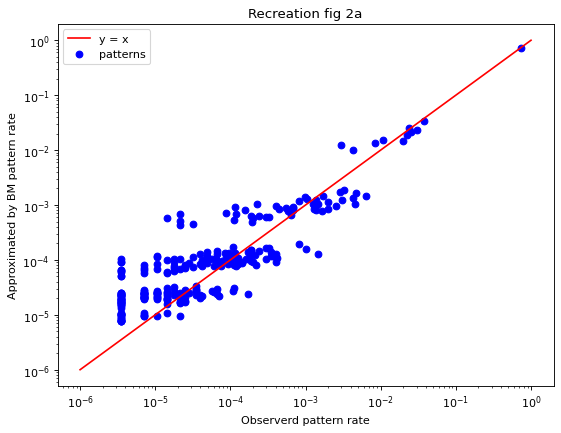

In [152]:
Z_mh = partition(w_mh_sal, theta_mh_sal, all_states)

approximated_rate_mh = p(new_data_set, w_mh_sal, theta_mh_sal, Z_mh)

plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
# plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_mh, label = "patterns", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_with_indep")
plt.show()

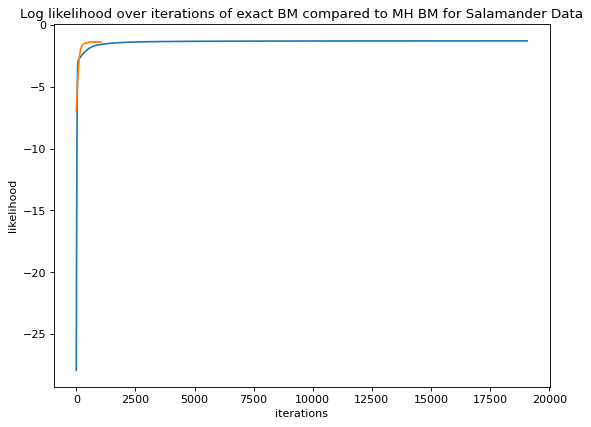

In [154]:

plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.plot([x for x in range(len(likelihoods_exact_sal))], likelihoods_exact_sal)
plt.plot([x for x in range(len(liks_mh_sal))], liks_mh_sal)
plt.xlabel("iterations")
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM compared to MH BM for Salamander Data")
plt.show()

## MF and LR sampling

In [87]:
def MF_LR_Sampler(w,theta, m_threshold):
    # first needed to calculate the m's, through some fixed point iteration
    m = np.random.randn(len(theta))
    m = np.clip(m, -1, 1)
    i = 0 
    error = np.inf
    while error > m_threshold: 
        i += 1
        m_new = np.tanh(np.dot(w,m) + theta)        
        error = np.max(np.abs(m_new - m))
        # if i %1 == 0:            
        #     print(error)
        #     print(m)
        #     print(m_new)
        m = m_new
    single_free = np.copy(m)
    A = np.zeros_like(w)
    np.fill_diagonal(A, 1/(1-m**(2)))
    A = A - w
    
    ksi = np.linalg.inv(A)
    outer_m = np.outer(m,m)
    double_free = ksi + outer_m
    return single_free, double_free

In [88]:
w_mf, theta_mf,liks_mf = BM(train_salamander_part, 1e-3, 3e-6, momentum = 0, MF_LR_stats=True, m_threshold=1e-10)

500
4.716506058943581e-05
1000
1.4083403069006795e-05
1500
1.2604712199346945e-05
2000
1.0680669117578977e-05
2500
1.0212378468505979e-05
3000
7.410876533757715e-06
3500
6.246115711607269e-06
4000
5.918281279975179e-06
4500
5.7560089292021945e-06
5000
5.631134807385086e-06
5500
5.531247544937612e-06
6000
5.435105927553557e-06
6500
5.430578074687581e-06
7000
5.216547164337421e-06
7500
5.193232132715969e-06
8000
5.139666432523865e-06
8500
5.071210135888099e-06
9000
5.005191610255866e-06
9500
4.87451664703091e-06
10000
4.884807253517503e-06
10500
4.8770272571913364e-06
11000
4.834360330883657e-06
11500
4.71015521624759e-06
12000
4.738409583223222e-06
12500
7.957049529333402e-06
13000
4.721659443960406e-06
13500
4.603380993672413e-06
14000
4.609450805358652e-06
14500
4.600921432554683e-06
15000
4.573654517966976e-06
15500
4.542564620206163e-06
16000
4.512992052409827e-06
16500
5.295356782250085e-06
17000
4.302431166970794e-06
17500
4.339366142778779e-06
18000
4.357962471198511e-06
18500
4.

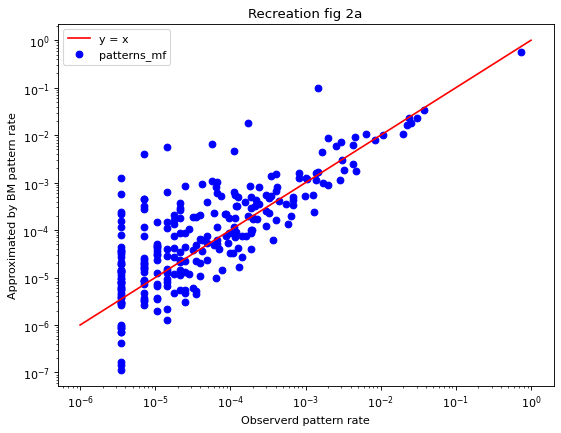

In [89]:
Z_mf = partition(w_mf, theta_mf, all_states)

approximated_rate_mf = p(new_data_set, w_mf, theta_mf, Z_mf)

plt.figure(figsize = (8,6), dpi = 80)
# plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_mf, label = "patterns_mf", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.show()

[[ 0.00000000e+00  7.32849346e-02  3.89109604e-02  7.30914862e-02
   9.10222904e-01 -2.03726313e-01  7.41707487e-01  2.51382688e-01
  -2.33589645e-01  3.26591009e-01]
 [ 7.32849346e-02  0.00000000e+00  5.49543055e-02  7.58675224e-01
   1.89789260e-01  6.44536238e-02 -1.52195430e-01  3.23842405e-01
  -6.30505985e-02 -2.69266302e-04]
 [ 3.89109604e-02  5.49543055e-02  0.00000000e+00  2.18236289e-01
  -1.68264828e-01  7.35437993e-01  3.49373729e-03  4.20375971e-01
   3.01035436e-01  1.36941296e-01]
 [ 7.30914862e-02  7.58675224e-01  2.18236289e-01  0.00000000e+00
   1.53311995e-03  1.18992645e-01 -2.53714275e-01  4.62860997e-01
   1.52303101e-01  5.18112966e-03]
 [ 9.10222904e-01  1.89789260e-01 -1.68264828e-01  1.53311995e-03
   0.00000000e+00  7.95324961e-03  6.52615466e-01  5.73743274e-02
   1.08884990e-01 -8.31869231e-02]
 [-2.03726313e-01  6.44536238e-02  7.35437993e-01  1.18992645e-01
   7.95324961e-03  0.00000000e+00  3.65998775e-01  1.83368513e-01
  -4.89171233e-03  3.38258623e-01